In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
!git clone https://github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'MOD2NN'...
remote: Enumerating objects: 204, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 204 (delta 111), reused 165 (delta 81), pack-reused 0
Receiving objects: 100% (204/204), 2.60 MiB | 11.13 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Mounted at /content/drive


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sys
import pandas as pd
from layers import InputToCx, CxMO, FreeSpacePropagation, CxD2NNIntensity, D2NNMNISTDetector, ImageResize, D2NNMNISTFilter, CxD2NNFaradayRotation

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)
print("OpenCV:", cv2.__version__)

plt.rcParams['font.size'] = 18

TensorFlow: 2.8.0
Python: 3.8.11 (default, Aug 16 2021, 12:04:33) 
[Clang 12.0.0 ]
OpenCV: 4.5.2


shape : ((rcp or lcp), (x_real, x_image, y_real, y_image), width, height)
右ねじが進む方向で正

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [3]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)


def loss_MSE(y_hat, y):
    return tf.reduce_sum((y_hat - y) ** 2)

In [3]:
#@title デフォルトのタイトル テキスト
wavelength = 633.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}

k = 2 * np.pi / wavelength

In [8]:
shape = (100, 100)

inputs = tf.keras.Input((28, 28))
x = ImageResize(shape)(inputs)
x = InputToCx(shape)(x)
x = CxMO(shape, limitation='tanh', limitation_num=10*np.pi/180)(x)
x = FreeSpacePropagation(shape, k, 0.5e-3, normalization='max', input_pitch=1.0e-6, output_pitch=1.0e-6)(x)
x = CxD2NNIntensity(shape)(x)
x = D2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

epochs = 10
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    min_delta=0.05,
    patience=2,
)

result = model.fit(x_train,
                   y_train,
                   batch_size=64,
                   epochs=epochs
                   #callbacks=[early_stopping]
                   )

path = "trained_model/20220317_4"
model.save(path)

df = pd.DataFrame(result.history)
df.to_csv(path + "/history.csv")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resize_1 (ImageResize  (None, 100, 100)         0         
 )                                                               
                                                                 
 input_to_cx_1 (InputToCx)   (None, 2, 4, 100, 100)    0         
                                                                 
 cx_mo_1 (CxMO)              (None, 2, 4, 100, 100)    10000     
                                                                 
 free_space_propagation_1 (F  (None, 2, 4, 100, 100)   0         
 reeSpacePropagation)                                            
                                                                 
 cx_d2nn_intensity (CxD2NNIn  (None, 100, 100)         0   

2022-03-18 16:19:35.837597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

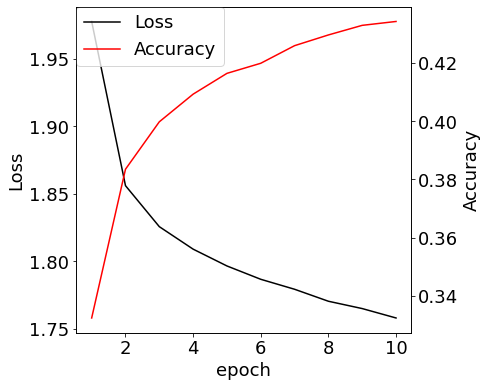

In [5]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), result.history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, epochs + 1), result.history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

In [6]:
model.evaluate(x_test, y_test)

2022-03-16 12:02:32.917280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 57s 180ms/step - loss: 0.5076 - accuracy: 0.8537


[0.5075562000274658, 0.8537000417709351]

In [9]:
layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
filter_y = D2NNMNISTFilter((100, 100))(model.get_layer(layer_name).output)
filter_model = tf.keras.Model(inputs=model.input, outputs=filter_y)

2022-03-18 16:19:43.214392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-18 16:19:43.660643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-18 16:19:44.173382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


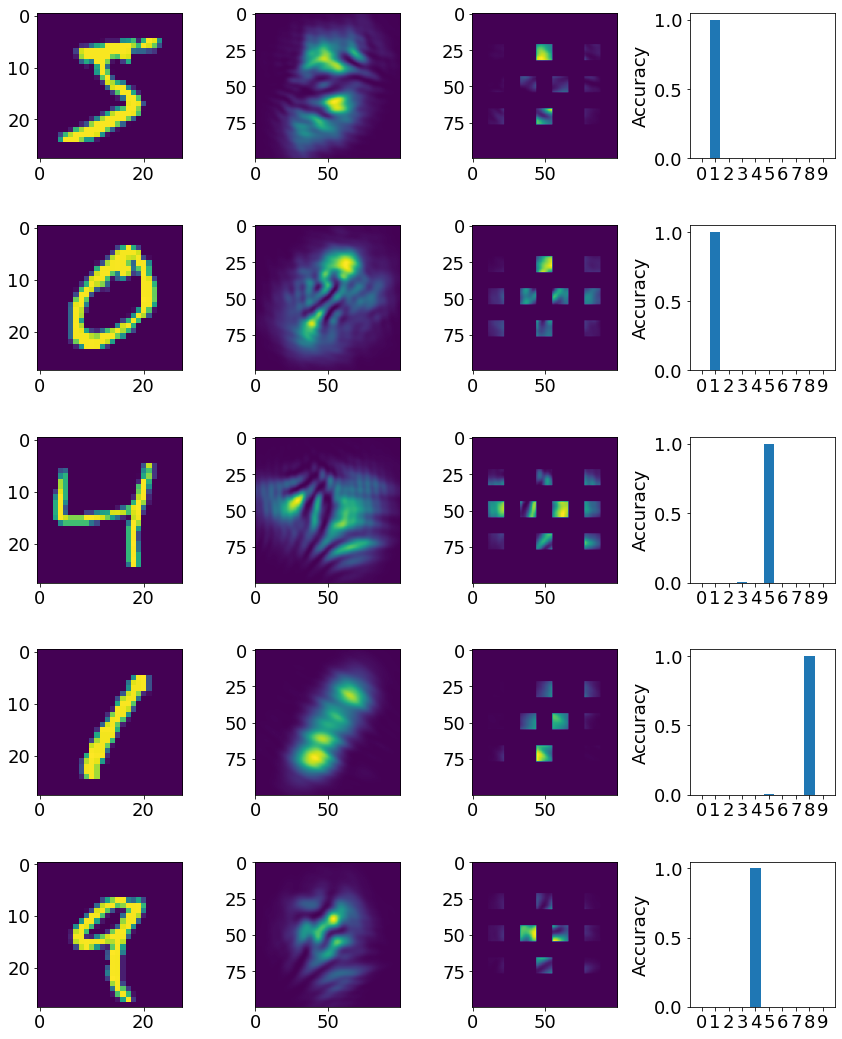

In [10]:
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
filtered_images = filter_model.predict(images)
fig, axes = plt.subplots(num, 4, figsize=(12, 3 * num))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].imshow(filtered_images[i,:,:])
    axes[i, 3].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 3].set_xticks(np.arange(0, 10, 1))
    axes[i, 3].set_ylabel('Accuracy')
    axes[i, 3].set_aspect(1./axes[i, 3].get_data_ratio())
fig.tight_layout()

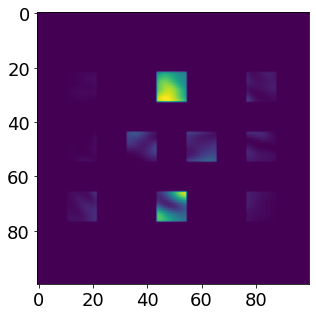

In [16]:
plt.figure(figsize=(5,5))
plt.imshow(filtered_images[0,:,:])

In [ ]:
layer_outputs = [layer.output for layer in model.layers[1:]]
layer_outputs

In [ ]:
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

In [ ]:
num = 5
images = x_train[0:num, :, :]
activations = activation_model.predict(images)
len(activations)

In [ ]:
fig, axes = plt.subplots(num, len(activations) - 2, figsize=(2 * len(activations) - 1, 2 * num))
for i in range(len(activations) - 2):
    layer_activation = activations[i]
    for j in range(num):
        intensity = tf.sqrt(layer_activation[j, 0, :, :] ** 2 + layer_activation[j, 1, :, :] ** 2)
        axes[j, i].imshow(intensity)

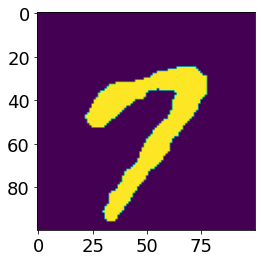

In [ ]:
# ---------------------------------------------------------
pt = np.loadtxt('./data/phase/100px/train_7.csv')
pt[pt == 1] = 4 * np.pi / 180
pt[pt == 0] = -4 * np.pi / 180
plt.imshow(pt)

In [ ]:
shpae = (100, 100)
inputs = keras.Input(shpae)
x = InputToCx(shpae)(inputs)
x = CxMO(shpae)(x)
# x = FreeSpacePropagation(shpae, k, 0.5e-3)(x)
x = CxD2NNFarraday(shpae)(x)

model = tf.keras.Model(inputs, x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100)]        0         
_________________________________________________________________
input_to_cx_1 (InputToCx)    (None, 2, 2, 100, 100)    0         
_________________________________________________________________
cx_mo_1 (CxMO)               (None, 2, 2, 100, 100)    10000     
_________________________________________________________________
cx_d2nn_farraday_1 (CxD2NNFa (None, 100, 100)          0         
Total params: 10,000
Trainable params: 10,000
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers[2].set_weights([pt])

In [ ]:
beam = np.ones(shape=shpae)
pred = model.predict(np.array([beam]))
pred.shape

(1, 100, 100)

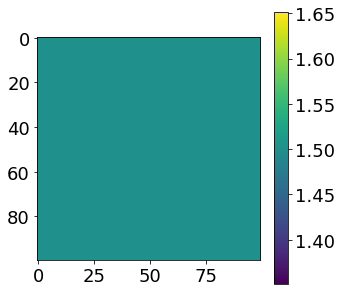

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(pred[0,:,:])
plt.colorbar()